# Necessary installations

In [1]:
!pip install numpy
!pip install matplotlib
!pip install ucimlrepo
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Import Statements

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
import random
import time  # Importing time module for tracking elapsed time
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

In [3]:
url = 'https://raw.githubusercontent.com/jamiehadd/QuantileRKIandPerceptron/refs/heads/main/functions_QRK.py'
!wget --no-cache --backups=1 {url}
from functions_QRK import perceptronModified

--2025-04-20 11:10:50--  https://raw.githubusercontent.com/jamiehadd/QuantileRKIandPerceptron/refs/heads/main/functions_QRK.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2693 (2.6K) [text/plain]
Saving to: ‘functions_QRK.py’

functions_QRK.py    100%[===================>]   2.63K  --.-KB/s    in 0s      

2025-04-20 11:10:50 (47.5 MB/s) - ‘functions_QRK.py’ saved [2693/2693]



# Sampled Indices: Timing them

# Real World Data Set: Banknote Authentication

In [ ]:
# Fetch the Banknote Authentication Dataset
banknote_data = fetch_ucirepo(id=267)

# Extract features and target
X = banknote_data.data.features # Features (variance, skewness, etc.)
y = banknote_data.data.targets

X = X.values
y = y.values
y = y.ravel()
y = 2*y-1 # to make it fit our algorithm

# Scale the features (standardize them)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_T = X_scaled.T

In [4]:
'''
Code to read the csv of our github url: generated with the help of Gemini in case import fails. The csv was downloaded from the 
source mentioned below.
Source: Lohweg, V. (2012). Banknote Authentication [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C55P57.
'''

import pandas as pd
import requests
import certifi
from io import StringIO

url2 = 'https://raw.githubusercontent.com/jamiehadd/QuantileRKIandPerceptron/refs/heads/main/banknote_authentication.csv'
cert_path = certifi.where()

try:
    response = requests.get(url2, verify=cert_path)
    response.raise_for_status()  # Raise an exception for bad status codes

    csv_content = StringIO(response.text)
    df = pd.read_csv(csv_content)

except requests.exceptions.RequestException as e:
    print(f"Error fetching URL: {e}")
except pd.errors.ParserError as e:
    print(f"Error parsing CSV data: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


X = df.iloc[:, :4].values # read the first 4 columns
y = df.iloc[:, 4:].values # read the labels

y = y.ravel()
y = 2*y-1 # to make it fit our algorithm

# Scale the features (standardize them)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_T = X_scaled.T

# We set the SVM baseline

In [5]:
# We will train on the full dataset without any random split
svm = SVC(kernel='linear')  # Linear kernel for decision boundary
svm.fit(X_scaled, y)  # Train on the full dataset to get linear truth labels

# Predict the labels using the trained model
y_pred = svm.predict(X_scaled)

# Evaluate the predictions by comparing with the true labels
accuracy = accuracy_score(y, y_pred)
report = classification_report(y, y_pred)

print(f"Accuracy of SVM classifier with linear kernel: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

incorrectly_classified = np.where(y != y_pred)[0]
misclassified = 1 - accuracy # just to store the values

Accuracy of SVM classifier with linear kernel: 98.47%
Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.97      0.99       762
           1       0.97      1.00      0.98       610

    accuracy                           0.98      1372
   macro avg       0.98      0.99      0.98      1372
weighted avg       0.99      0.98      0.98      1372



In [6]:
'''
Code to check how balanced is the dataset.
'''

count_ones = np.sum(y == 1)
count_minus_ones = np.sum(y == -1)

print(f"Number of 1s in y: {count_ones}")
print(f"Number of -1s in y: {count_minus_ones}")

Number of 1s in y: 610
Number of -1s in y: 762


In [7]:
'''
Setting the parameters for the algorithm
'''

numDataPoints = X_scaled_T.shape[1]
numMislabelled = len(incorrectly_classified)
correct_labels = y_pred
data = X_scaled_T
labels = y
t = numDataPoints
N = 5000

In [8]:
quantile_list = [0.85, 0.9, 0.95, 0.97]
residual_list = []  # Dictionary to store residuals for each quantile
nTrials = 10 # how many rounds of averaging we wish to do

for q in quantile_list:
  intermediateResiduals = []
  for i in range(nTrials):
      x, residuals, _ = perceptronModified(data, labels, q, numDataPoints, N, correct_labels, numMislabelled, numDataPoints)
      intermediateResiduals.append(residuals)

  intermediateResiduals = np.mean(intermediateResiduals, axis = 0)
  residual_list.append(intermediateResiduals)

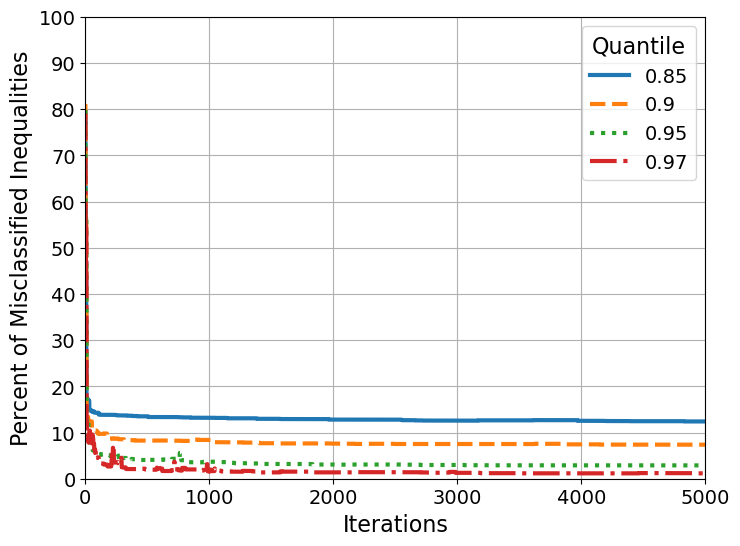

In [9]:
import numpy as np
import matplotlib.pyplot as plt


line_styles = ['-', '--', ':', '-.']

# Create a plot
plt.figure(figsize=(8, 6))

for idx, residuals in enumerate(residual_list):
    # Ensure x matches the length of residuals (assuming iteration count is equal to len(residuals))
    x = np.arange(len(residuals))

    plt.plot(x, residuals, label=f'{quantile_list[idx]}', linestyle=line_styles[idx], linewidth=3)


plt.xlim(0, N)
plt.ylim(20, 80)
plt.yticks(np.arange(0, 110, 10), fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Percent of Misclassified Inequalities', fontsize=16)
plt.legend(title='Quantile', fontsize=14, title_fontsize=16)
plt.grid(True)
plt.savefig('banknotes_data_final_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
sampled_indices_list = [450, 900, 1372]
line_styles = ['-', '--', ':']
markers = ['o', 's', '*']

In [11]:
residual_list = []
residual_errors = []
residual_dict = {}
error_dict = {}

for t in sampled_indices_list:
    residual_list_i = []
    residual_errors_i = []
    for i in range(nTrials):
        x, residuals, residuals_time = perceptronModified(data, labels, 0.97, t, N, correct_labels, numMislabelled, numDataPoints)
        residual_list_i.append(residuals_time)
        residual_errors_i.append(residuals)

    avg_residual_time = np.mean(residual_list_i, axis=0)
    avg_residual_error = np.mean(residual_errors_i, axis=0)
    residual_list.append(avg_residual_time)
    residual_errors.append(avg_residual_error)
    residual_dict[t] = avg_residual_time
    error_dict[t] = avg_residual_error

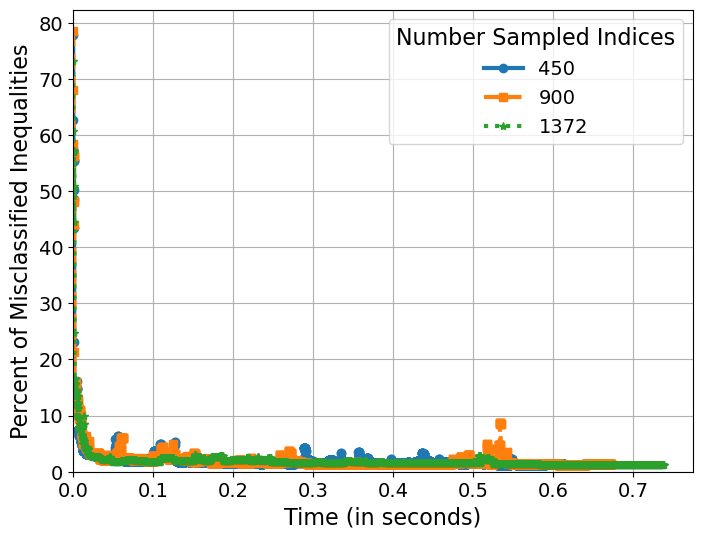

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for idx, t in enumerate(sampled_indices_list):
    x_values = residual_dict[t]
    y_values = error_dict[t]

    line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]

    plt.plot(x_values, y_values, label=f'{t}', linestyle=line_style, marker=marker, linewidth=3)

plt.xlabel('Time (in seconds)', fontsize=16)
plt.ylabel('Percent of Misclassified Inequalities', fontsize=16)
plt.legend(title='Number Sampled Indices', fontsize=14, title_fontsize=16, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, which='both', axis='both')
plt.xlim(left=0)
plt.ylim(bottom=0)

# Save the figure as a PNG file
plt.savefig('time_sampled_indices_q_equals_0.97_5000_banknotes_final_iterations.png', dpi=300, bbox_inches='tight')
plt.show()

# Occupancy dataset

In [ ]:
'''
Download directly from the uci ml repo
'''

occupancy_detection = fetch_ucirepo(id=357)
occupancy_detection.data.features = occupancy_detection.data.features.drop(columns=['date']) # Drop the 'date' column
# Convert numeric columns to the correct data type using .loc
occupancy_detection.data.features.loc[:, 'Temperature'] = pd.to_numeric(occupancy_detection.data.features['Temperature'], errors='coerce')
occupancy_detection.data.features.loc[:, 'Humidity'] = pd.to_numeric(occupancy_detection.data.features['Humidity'], errors='coerce')
occupancy_detection.data.features.loc[:, 'Light'] = pd.to_numeric(occupancy_detection.data.features['Light'], errors='coerce')
occupancy_detection.data.features.loc[:, 'CO2'] = pd.to_numeric(occupancy_detection.data.features['CO2'], errors='coerce')
occupancy_detection.data.features.loc[:, 'HumidityRatio'] = pd.to_numeric(occupancy_detection.data.features['HumidityRatio'], errors='coerce')

X = occupancy_detection.data.features
y = occupancy_detection.data.targets
# Drop NaN rows
X_clean = X.drop(index=[8143, 10809])
y_clean = y.drop(index=[8143, 10809])

# Convert y_clean to NumPy and transform it into {-1, 1}
y_clean = y_clean.values.ravel()
y_clean = 2 * y_clean - 1

In [13]:
'''
Download from github repository in case the direct uci ml repo data set import fails. The csv was downloaded from the 
source mentioned below.
Source: Candanedo, L. (2016). Occupancy Detection  [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5X01N.
'''


import requests
import certifi
from io import StringIO

# URL to CSV
url3 = 'https://raw.githubusercontent.com/jamiehadd/QuantileRKIandPerceptron/refs/heads/main/occupancy_detection%20(1).csv'
cert_path = certifi.where()

# Try fetching the data
try:
    response = requests.get(url3, verify=cert_path)
    response.raise_for_status()  # Raise an exception for bad status codes

    csv_content = StringIO(response.text)
    df = pd.read_csv(csv_content)

except requests.exceptions.RequestException as e:
    print(f"Error fetching URL: {e}")
except pd.errors.ParserError as e:
    print(f"Error parsing CSV data: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

df = df.drop(columns=['date']) # Drop the 'date' column

# Drop problematic rows
df = df.drop(index=[8143, 10809])

# Coerce the first 5 feature columns to numeric
for col in ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Split into features and labels
X = df.iloc[:, :5]  # First 5 columns
y = df.iloc[:, 5:]  # Remaining columns (labels)

# Convert y to {-1, 1}
y = 2 * y - 1

X_clean = X # for code consistency later on
y_clean = y.values.ravel() # for code consistency later on

# We set the SVM baseline again

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)
X_scaled_T = X_scaled.T

# We will train on the full dataset without any random split
svm = SVC(kernel='linear')
svm.fit(X_scaled, y_clean)
y_pred = svm.predict(X_scaled)
accuracy = accuracy_score(y_clean, y_pred)
report = classification_report(y_clean, y_pred)
print(f"Accuracy of SVM classifier with linear kernel: {accuracy * 100:.2f}%")
print("Classification Report:")
print(report)

# Identifying where the linear kernel fails:
incorrectly_classified = np.where(y_clean != y_pred)[0]

Accuracy of SVM classifier with linear kernel: 98.89%
Classification Report:
              precision    recall  f1-score   support

        -1.0       1.00      0.99      0.99     15810
         1.0       0.96      1.00      0.98      4750

    accuracy                           0.99     20560
   macro avg       0.98      0.99      0.98     20560
weighted avg       0.99      0.99      0.99     20560



In [15]:
numDataPoints = X_scaled_T.shape[1]
numMislabelled = len(incorrectly_classified)
correct_labels = y_clean  # we have no correct labels
data = X_scaled_T
labels = y_pred  # corrupted labels
t = numDataPoints
N = 5000

# Accuracy Plots

In [16]:
quantile_list = [0.85, 0.9, 0.92, 0.96]
residual_list = []
nTrials = 10 # number of trials for the algorithm

for q in quantile_list:
  intermediateResiduals = []
  for i in range(nTrials):
      x, residuals, _ = perceptronModified(data, labels, q, numDataPoints, N, correct_labels, numMislabelled, numDataPoints)
      intermediateResiduals.append(residuals)

  intermediateResiduals = np.mean(intermediateResiduals, axis = 0)
  residual_list.append(intermediateResiduals)  # Store residuals for each quantile

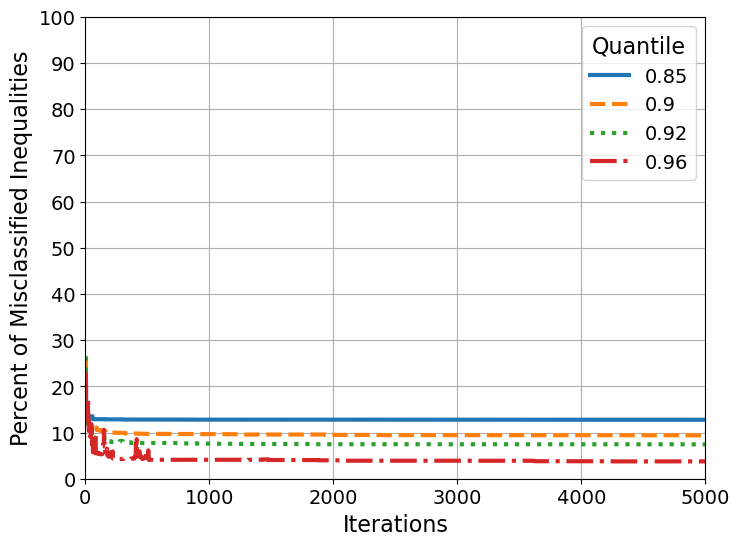

In [17]:
line_styles = ['-', '--', ':', '-.']

plt.figure(figsize=(8, 6))

for idx, residuals in enumerate(residual_list):
    x = np.arange(len(residuals))
    plt.plot(x, residuals, label=f'{quantile_list[idx]}', linestyle=line_styles[idx], linewidth=3)

plt.xlim(0, N)
plt.ylim(20, 80)
plt.yticks(np.arange(0, 110, 10), fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Percent of Misclassified Inequalities', fontsize=16)
plt.legend(title='Quantile', fontsize=14, title_fontsize=16)
plt.grid(True)
plt.savefig('Occupancy_final_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


# Timing the iterations

In [18]:
sampled_indices_list = [5000, 15000, 20560]
markers = ['o', 's', '*']

In [19]:
residual_list = []
residual_errors = []
residual_dict = {}
error_dict = {}
for t in sampled_indices_list:
    residual_list_i = []
    residual_errors_i = []
    for i in range(nTrials):
        x, residuals, residuals_time = perceptronModified(data, labels, 0.96, t, N, correct_labels, numMislabelled, numDataPoints)
        # Append the results for this iteration
        residual_list_i.append(residuals_time)  # residuals_time = time
        residual_errors_i.append(residuals)  # residuals = error

    avg_residual_time = np.mean(residual_list_i, axis=0)
    avg_residual_error = np.mean(residual_errors_i, axis=0)
    residual_list.append(avg_residual_time)
    residual_errors.append(avg_residual_error)
    residual_dict[t] = avg_residual_time
    error_dict[t] = avg_residual_error

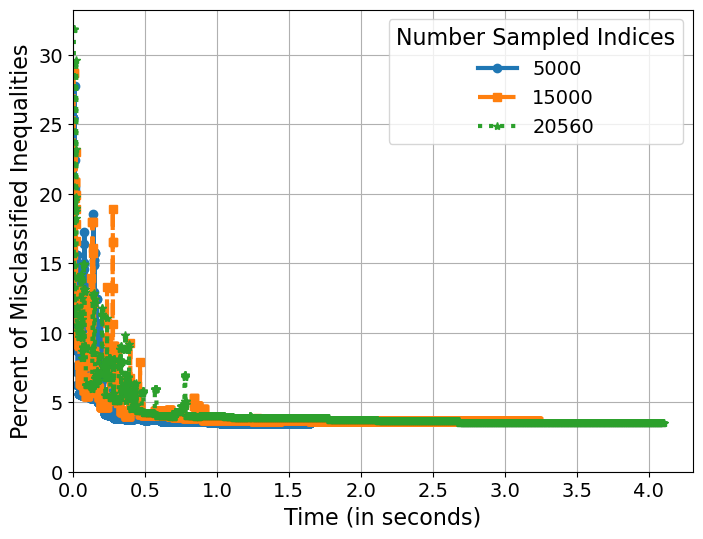

In [20]:
plt.figure(figsize=(8, 6))

for idx, t in enumerate(sampled_indices_list):
    x_values = residual_dict[t]
    y_values = error_dict[t]
    line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    plt.plot(x_values, y_values, label=f'{t}', linestyle=line_style, marker=marker, linewidth=3)

plt.xlabel('Time (in seconds)', fontsize=16)
plt.ylabel('Percent of Misclassified Inequalities', fontsize=16)
plt.legend(title='Number Sampled Indices', fontsize=14, title_fontsize=16, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, which='both', axis='both')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.savefig('time_sampled_indices_q_equals_0.96_5000_Occupancy_iterations.png', dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()